In [1]:
!pip install opencv-rolling-ball

In [30]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os  
import sys  
sys.path.insert(0, r'/home/ipausers/bisot/pycode/MscThesis')
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path, get_data_info, update_plate_info, \
get_current_folders, get_folders_by_plate_id

import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.node_id import orient
import scipy.io as sio
import cv2
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_graph import from_sparse_to_graph, generate_nx_graph
from amftrack.pipeline.functions.image_processing.extract_skel import extract_skel_new_prince,run_back_sub
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess
from decouple import Config, RepositoryEnv
import shutil


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
directory = r'/mnt/sun-temp/TEMP/PRINCE_analysis/'
update_plate_info(directory)

all_folders = get_current_folders(directory)

analysed:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
folders = all_folders.loc[all_folders['folder']=='20220420_0834_Plate12']


In [23]:
folder = '20220420_0834_Plate12'

In [24]:
%autoreload 2

run_back_sub(directory,folder)

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


20220420_0834_Plate12/


In [16]:
i = 0
run_info = folders
folder_list = list(run_info['folder'])
folder_list.sort()
directory_name = folder_list[i]
imname = '/Img2/Img_r08_c13.tif'

path_im = directory+directory_name+imname
im = imageio.imread(path_im)
imname = '/Img/Img_r06_c11.tif'
path_im = directory+directory_name+imname
im2 = imageio.imread(path_im)

In [31]:
%autoreload 2
params=[30]
perc_low = 93
perc_high = 99.5
connected = extract_skel_new_prince(im, params,perc_low,perc_high)

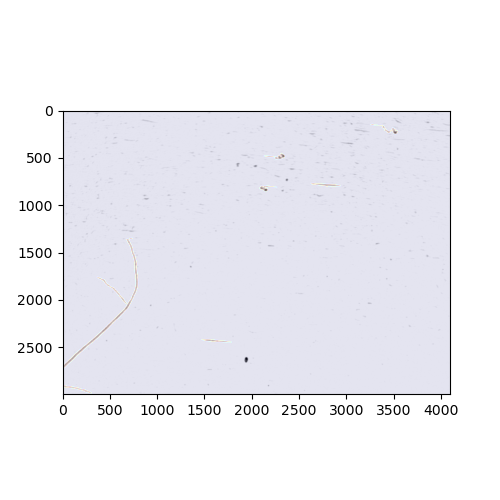

In [32]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(im,cmap='gray')
ax.imshow(connected,cmap='jet',alpha =0.1)

In [24]:
low = np.percentile(connected, perc_low)
high = max(70,np.percentile(connected, perc_high))
low,high

(3.0, 70)

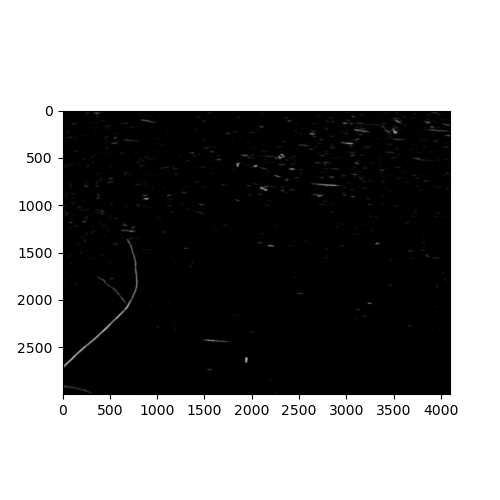

In [18]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(connected,cmap='gray')

In [26]:
hyst = filters.apply_hysteresis_threshold(connected, low, high)


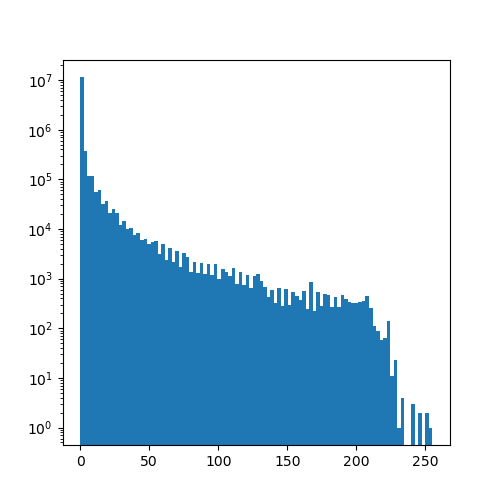

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.hist(np.ndarray.flatten(connected),100)
ax.set_yscale("log")

In [28]:
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)

In [29]:
/home/ipausers/bisot/miniconda3/envs/amftrack/bin/pyt

(27081, 52139)

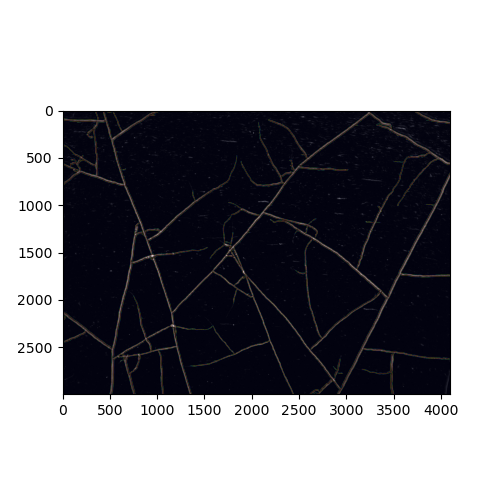

In [17]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(-im,cmap='gray')
ax.imshow(connected,alpha = 0.1,cmap='jet')

In [21]:
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
im_fold= "/Img2"
to_delete = directory + directory_name+im_fold
shutil.rmtree(to_delete)

In [58]:
kernel = np.ones((3,3),np.uint8)
dilation = cv.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
for i in range(3):
    dilation=cv.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilation = cv.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
dilated = dilation>0
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(dilated.astype(np.uint8), connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000  

#your answer image
img_f = np.zeros((dilated.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_f[output == i + 1] = 1
skeletonized = cv.ximgproc.thinning(np.array(255*img_f,dtype=np.uint8))
